## Tutorial for Random Forrest
#### Tutorial be found [here](https://towardsdatascience.com/a-practical-guide-to-implementing-a-random-forest-classifier-in-python-979988d8a263)

In [164]:
## Importing Scientific Libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

In [165]:
# Loading data in. 
df = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-07-07/coffee_ratings.csv')
df.head()


# Deciding paramaters for our model
coffee_df = df[['total_cup_points',
                            'species',
                            'country_of_origin',
                            'variety',
                            'aroma',
                            'aftertaste',
                            'acidity',
                            'body',
                            'balance',
                            'sweetness',
                            'altitude_mean_meters',
                            'moisture']]

# Dropping any data entries(rows) with missing values. 
coffee_df = coffee_df.dropna()

In [166]:
## Encoding categorical data. Things like species, country of origin, and variety need to be 
## put into a numerical value for processing

from sklearn.preprocessing import OrdinalEncoder

ord_enc = OrdinalEncoder()
coffee_df["species"] = ord_enc.fit_transform(coffee_df[["species"]])
coffee_df["country_of_origin"] = ord_enc.fit_transform(coffee_df[["country_of_origin"]])
coffee_df["variety"] = ord_enc.fit_transform(coffee_df[["variety"]])

coffee_df.head()

,total_cup_points,species,country_of_origin,variety,aroma,aftertaste,acidity,body,balance,sweetness,altitude_mean_meters,moisture
1,89.92,0.0,6.0,14.0,8.75,8.50,8.58,8.42,8.42,10.0,2075.0,0.12
2,89.75,0.0,7.0,2.0,8.42,8.42,8.42,8.33,8.42,10.0,1700.0,0.00
4,88.83,0.0,6.0,14.0,8.25,8.25,8.50,8.42,8.33,10.0,2075.0,0.12
9,88.25,0.0,6.0,14.0,8.08,8.50,8.50,7.67,8.42,10.0,1822.5,0.10
11,87.92,0.0,27.0,14.0,8.25,8.17,8.33,8.08,8.17,10.0,1872.0,0.00


<AxesSubplot:>

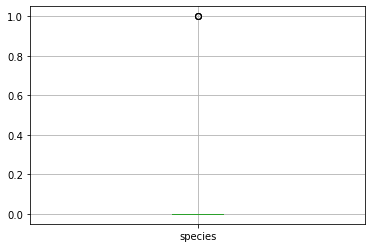

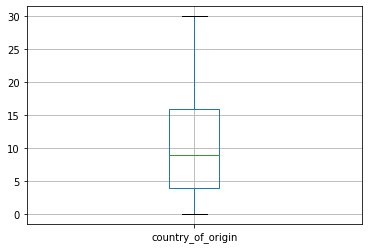

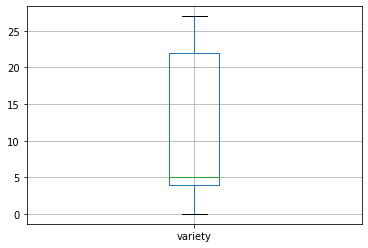

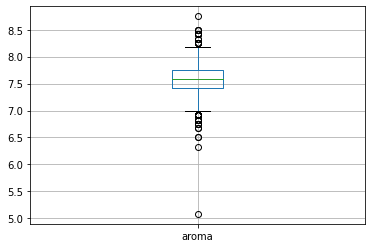

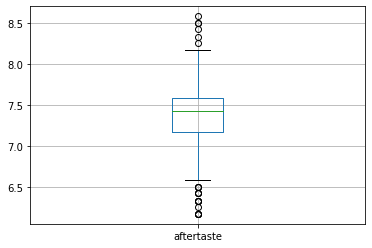

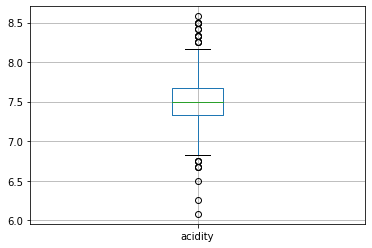

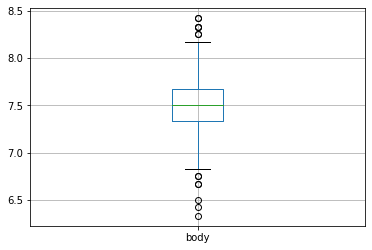

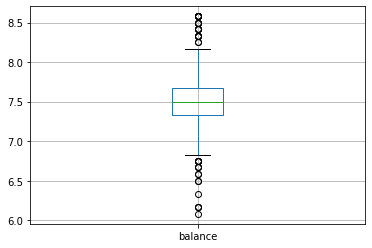

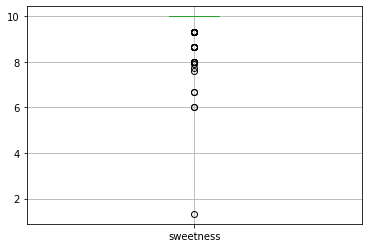

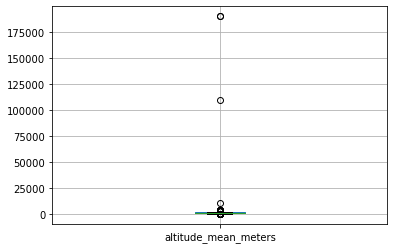

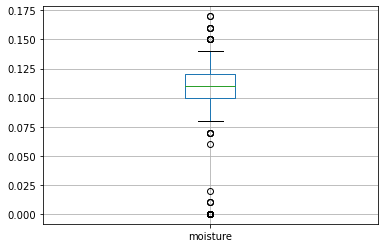

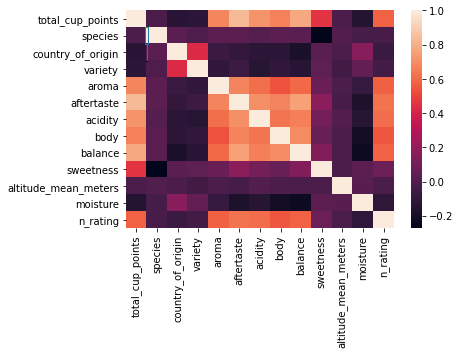

In [216]:
## Exploring Outliers
for column in coffee_df.drop('total_cup_points', axis = 1):
    plt.figure()
    coffee_df.drop('total_cup_points', axis = 1).boxplot([column])


## Removing outliers
coffee_df = coffee_df[coffee_df['aroma']>0]
coffee_df = coffee_df[coffee_df['acidity']>0]
coffee_df = coffee_df[coffee_df['aftertaste']>0]
coffee_df = coffee_df[coffee_df['body']>0]
coffee_df = coffee_df[coffee_df['balance']>0]

## Considering Correlations
seaborn.heatmap(coffee_df.corr(),
                xticklabels=coffee_df.columns,
                yticklabels=coffee_df.columns)

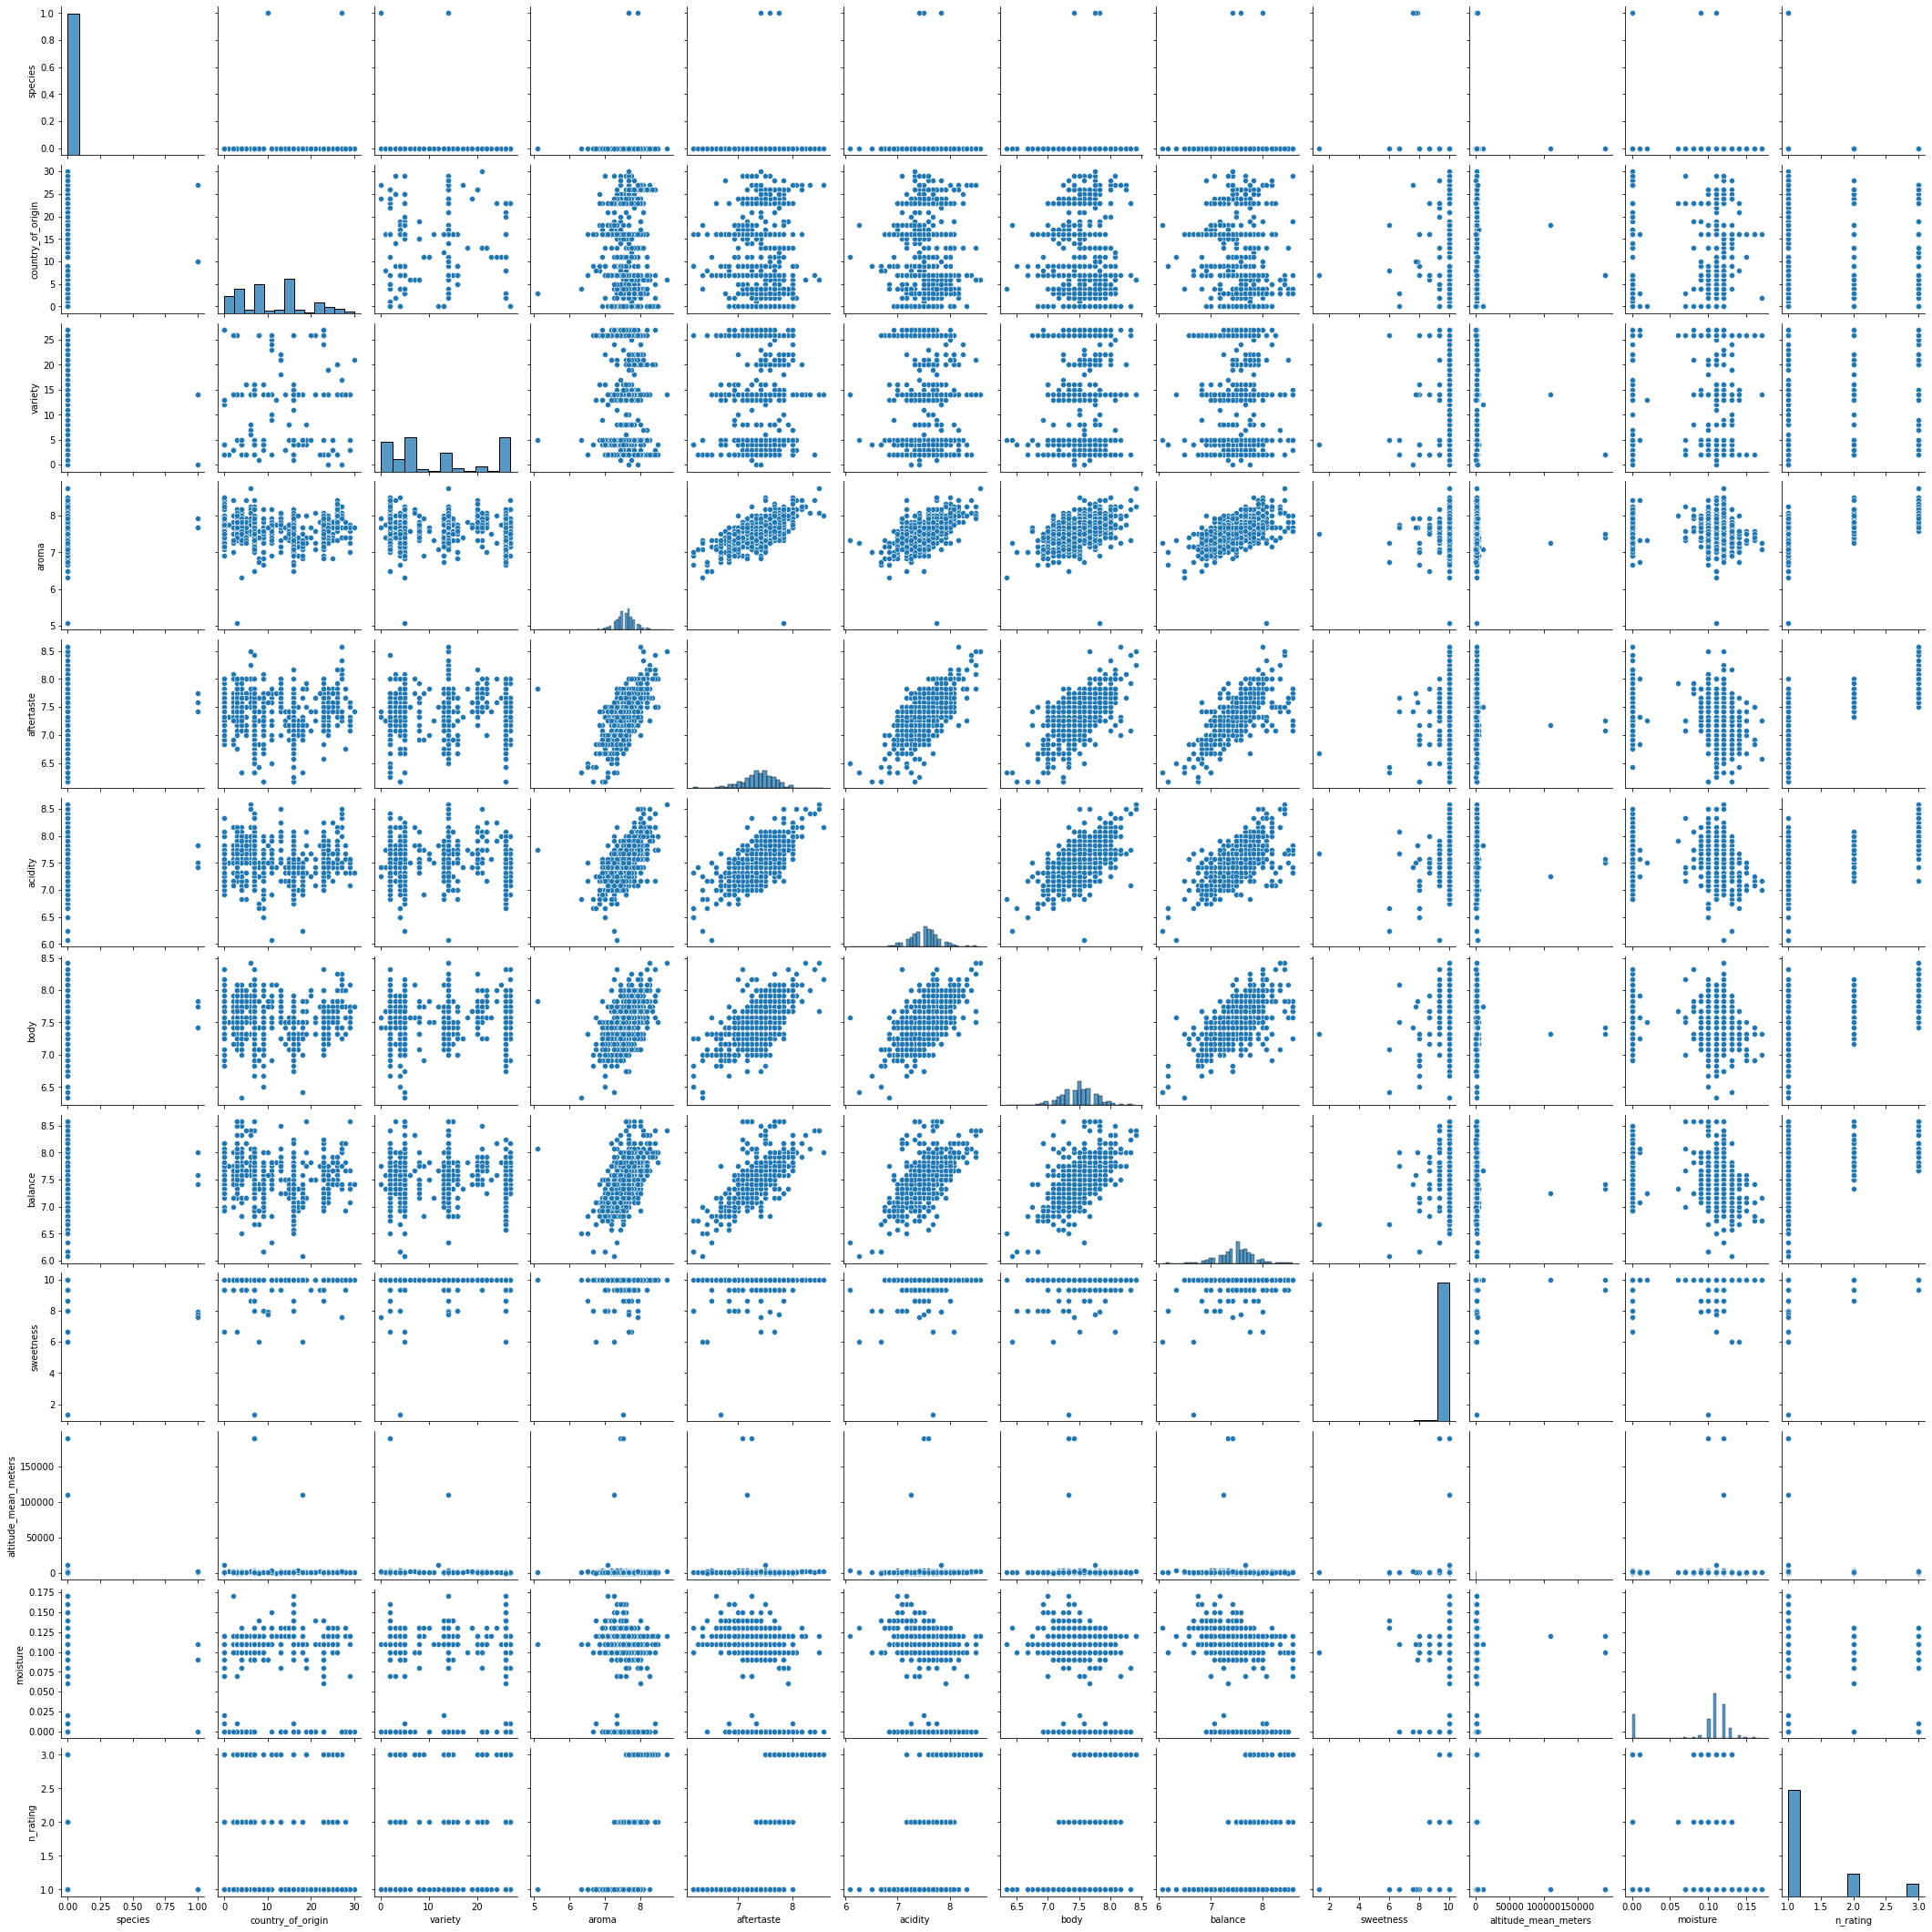

In [221]:
seaborn.pairplot(coffee_df.drop('total_cup_points', axis = 1))

[83.58 84.58]


,total_cup_points,species,country_of_origin,variety,aroma,aftertaste,acidity,body,balance,sweetness,altitude_mean_meters,moisture,n_rating
1,89.92,0.0,6.0,14.0,8.75,8.50,8.58,8.42,8.42,10.0,2075.0,0.12,3
2,89.75,0.0,7.0,2.0,8.42,8.42,8.42,8.33,8.42,10.0,1700.0,0.00,3
4,88.83,0.0,6.0,14.0,8.25,8.25,8.50,8.42,8.33,10.0,2075.0,0.12,3
9,88.25,0.0,6.0,14.0,8.08,8.50,8.50,7.67,8.42,10.0,1822.5,0.10,3
11,87.92,0.0,27.0,14.0,8.25,8.17,8.33,8.08,8.17,10.0,1872.0,0.00,3


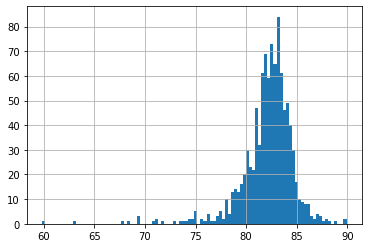

In [217]:
## Classification parameters. Coffee ratings are continous in the data. Consider the following, 
coffee_df['total_cup_points'].hist(bins = 100)
## We will classify a coffee as bad, average, and good.
    ## >75 bad
    ## 75< average <90
    ## <90 good
    
    
rating_pctile = np.percentile(coffee_df['total_cup_points'], [75, 90])
print(rating_pctile)
    ## So anything below 83.58 is a bad coffee,
    ## anything above 84.58 is a good coffee. 
    
    
## Creating a new data column to classify our data. 1 is bad, 2 is average, and 3 is good. 
coffee_df['n_rating'] = 0
coffee_df['n_rating'] = np.where(coffee_df['total_cup_points'] < rating_pctile[0], 1, coffee_df['n_rating'])
coffee_df['n_rating'] = np.where((coffee_df['total_cup_points'] >= rating_pctile[0]) & (coffee_df['total_cup_points'] <= rating_pctile[1]), 2, coffee_df['n_rating'])
coffee_df['n_rating'] = np.where(coffee_df['total_cup_points'] > rating_pctile[1], 3, coffee_df['n_rating'])

coffee_df.head()



In [218]:
## Splitting into our training and testing data. 
from sklearn.model_selection import train_test_split

X = coffee_df.drop(['total_cup_points', 'n_rating', 'sweetness', 'species', 'altitude_mean_meters'], axis = 1)
y = coffee_df['n_rating']

training, testing, training_labels, testing_labels = train_test_split(X, y, test_size = .25, random_state = 42)

## Normalizing the dataset so large values don't overfit our model. 
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
normed_train_data = pd.DataFrame(sc.fit_transform(training), columns = X.columns)
normed_test_data = pd.DataFrame(sc.fit_transform(testing), columns = X.columns)



In [219]:
## Training our random forest classifier
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier()
clf.fit(training, training_labels)
preds = clf.predict(testing)

## evaluating the score on the training data
    ## Score gives an estimate of the mean accuracy
    ## With a training score of 100% we can see that the model is overfitting. 
print(clf.score(training, training_labels))
## evaluating the score on the testing data
print(clf.score(testing, testing_labels))

from sklearn.metrics import confusion_matrix
print(confusion_matrix(testing_labels, preds,labels = [1, 2, 3]))



## Looking at how the random forest model favors each paramater. 
pd.DataFrame(clf.feature_importances_, index=training.columns).sort_values(by=0, ascending=False)


1.0
0.8714859437751004
[[183   6   1]
 [ 10  20   2]
 [  0  13  14]]


,0
aftertaste,0.225107
balance,0.200517
acidity,0.178814
aroma,0.140975
body,0.121121
country_of_origin,0.052055
variety,0.043054
moisture,0.038356


In [220]:
## Since overfitting is occuring we need to tune our model to the optimal settings, 
## the method defined in the tutorial describes creating a random grind of paramaters and 
## retraining the model until we find the highest performing paramaters. 

## METHOD OF RANDOMIZED GRID SEARCH

# Number of trees in random forest
n_estimators = np.linspace(100, 3000, int((3000-100)/200) + 1, dtype=int)
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [1, 5, 10, 20, 50, 75, 100, 150, 200]# Minimum number of samples required to split a node
# min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 10, num = 9)]
min_samples_split = [1, 2, 5, 10, 15, 20, 30]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Criterion
criterion=['gini', 'entropy']
random_grid = {'n_estimators': n_estimators,'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion': criterion}


from sklearn.model_selection import RandomizedSearchCV
rf_base = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf_base, param_distributions = random_grid, n_iter = 30, cv = 5, verbose=2, random_state=42, n_jobs = 4)
rf_random.fit(training, training_labels)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


KeyboardInterrupt: 

In [ ]:
rf_random.best_params_
print (rf_random.score(training, training_labels))
print(rf_random.score(testing, testing_labels))